# Smash Match Analyzer
### DTSC 3000 Project, James Sprague

This project is a proof of concept for a tool that keeps track of what is happening in a Super Smash Bros Ultimate match based on what we can detect from looking at the game's UI. In the current version of this project, we are detecting what characters the player is using and when a stock is taken in a "Squad Strike" match. (The character the player uses switches after they lose their life.) Data is output into text files, which are then read by our streaming program and displayed on-screen. This includes a file that shows how many points each player has, another file for their currently selected characters, and another file that acts as a log for when a character is switched and how long their life lasted. 

The current version of the model was created in Roboflow, and has separate classes for the first 8 characters in the game. The model has 159 images in total, with roughly 20 images for each character, showing different character costumes, port backgrounds, and stage backgrounds.

Demo Video: https://m.youtube.com/watch?v=-jo6xUL1RRE

Github repo (w/ model and other files): https://github.com/j-sprague/computervision-project-ssbu

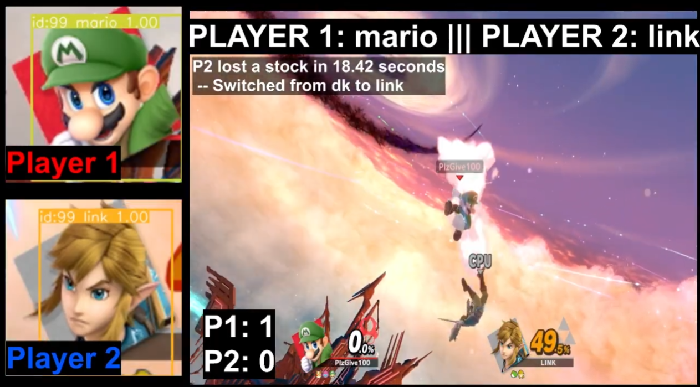

In [1]:
import cv2
from ultralytics import YOLO
import time

In [28]:
# Load the YOLOv8 model
model = YOLO('best.pt')

* **nothing_detect, nothing_time**: Variables meant to keep track of how many times nothing was detected in a row, as well as the time the first "nothing" detection occurred. Meant to determine the end of a match and the time the match ended.

* **clear()**: Clears the three text files our code will output to

* **chars**: List of each character in the order they are referred to in our model

p1 and p2 dictionaries
* **char, spawntime**: Current confirmed character, as well as time it was first detected
* **last, checks, temptime**: Last character that was detected, as well as how many times they have been detected, and the time it was first detected. If the new character has been detected 3 times, we will replace the current confirmed character.
* **taken**: The stocks each player has taken. If a new character is detected, their stock is lost, so the other player will gain a point.

In [33]:
nothing_detect = 0
nothing_time = 0

def clear(file):
    f = open(file, "w")
    f.write("")
    f.close()

clear("ko_feed.txt")
clear("stocks_taken.txt")
clear("overlay_data.txt")

chars = ["dk" , "fox", "kirby", "link", "mario", "pikachu", "samus", "yoshi", "unknown"] 

p1 = dict(dict.fromkeys(["char","last","checks","spawntime","temptime","taken"], 0))
p2 = dict(dict.fromkeys(["char","last","checks","spawntime","temptime","taken"], 0))

p1["char"] = 8
p2["char"] = 8
p1["last"] = 8
p2["last"] = 8

## Simplified Steps 
1. Open capture card, and create frames for each of the player portraits
2. Run detection on both frames
3. Depending on what we've detected:
     * If the current confirmed character is detected again, set "checks" to 0 since we can confirm current character still exists.
     * New character we haven't seen before: change "last" variable to it, add 1 to checks, and keep track of the time this detection happened
     * New character we've seen 1-2 times in a row: add 1 to checks.
     * New character we've seen 3 times in a row: Change our current char and spawntime values to match this new character, since we've detected it 3 times in a row.
4. Update ko_feed, overlay_data, and stocks_taken text files with our new data 

**If nothing is detected in our frames for 13 checks**
1. Check to see if the game ended. If our P1 and P2 values are still default values, the game hasn't started yet, so we must go back and wait for the game to start. Otherwise, proceed.
2. Look at the RGB values of a certain pixel on the game-end screen to see if P1 or P2 won. (Red for P1, Blue for P2)
3. Update text files with more match data

In [ ]:
# Open the capture card
cap = cv2.VideoCapture(2)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

# Loop through the video frames
while cap.isOpened():
    time.sleep(0.33)
    # Read a frame from the video
    success, frame = cap.read()
    cropped1 = frame[592:695,253:363]
    cropped1 = cv2.resize(cropped1, (250, 250))
    cropped2 = frame[592:695,745:861]
    cropped2 = cv2.resize(cropped2, (250, 250))
    if success:
        
        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results1 = model.track(cropped1, persist=True, conf=0.85, verbose=False)
        results2 = model.track(cropped2, persist=True, conf=0.85, verbose=False)
        # Visualize the results on the frame
        annotated_frame1 = results1[0].plot()
        annotated_frame2 = results2[0].plot()
        # Display the annotated frame
        cv2.imshow("ssbu_char tracker1", annotated_frame1)
        cv2.imshow("ssbu_char tracker2", annotated_frame2)
        
        result1 = results1[0].cpu().boxes
        result2 = results2[0].cpu().boxes
        
        if result2.cls.tolist() != [] or result1.cls.tolist() != []:
            nothing_detect = 0
            nothing_time = 0
            
            detect_id1 = result1.cls.tolist() if result1.cls != None else []
            detect_id2 = result2.cls.tolist() if result2.cls != None else []
            
            if detect_id1 != []:
                p1["detect"] = detect_id1[0]
                if p1["detect"] != p1["char"]:
                    if p1["detect"] == p1["last"]:
                        if p1["checks"] > 2:
                            if p1["spawntime"] != 0:
                                f = open("ko_feed.txt", "a")
                                f.write("P1 lost a stock in " + str(round(p1["temptime"] - p1["spawntime"], 2)) + " seconds\n")
                                f.write(" -- Switched from " + chars[int(p1["char"])] + " to " + chars[int(p1["detect"])] + "\n")
                                f.close()
                                p2["taken"] += 1
                            p1["char"] = p1["detect"]
                            p1["spawntime"] = p1["temptime"]
                        else:
                            p1["checks"] += 1
                    else:
                        p1["checks"] = 1
                        p1["last"] = p1["detect"]
                        p1["temptime"] = time.time()
                else:
                    p1["checks"] = 0
                    p1["last"] = p1["detect"]
            
            if detect_id2 != []:
                p2["detect"] = detect_id2[0]
                if p2["detect"] != p2["char"]:
                    if p2["detect"] == p2["last"]:
                        if p2["checks"] > 2:
                            if p2["spawntime"] != 0:
                                f = open("ko_feed.txt", "a")
                                f.write("P2 lost a stock in " + str(round(p2["temptime"] - p2["spawntime"], 2)) + " seconds\n")
                                f.write(" -- Switched from " + chars[int(p2["char"])] + " to " + chars[int(p2["detect"])] + "\n")
                                f.close()
                                p1["taken"] += 1
                            p2["char"] = p2["detect"]
                            p2["spawntime"] = p2["temptime"]
                        else:
                            p2["checks"] += 1
                    else:
                        p2["checks"] = 1
                        p2["last"] = p2["detect"]
                        p2["temptime"] = time.time()
                else:
                    f = open("overlay_data.txt", "w")
                    f.write("PLAYER 1: " + chars[int(p1["char"])] + " ||| PLAYER 2: " + chars[int(p2["char"])])
                    f.close()
                    f = open("stocks_taken.txt", "w")
                    f.write("P1: " + str(p1["taken"]) + "\nP2: " + str(p2["taken"]))
                    f.close()
                    p2["checks"] = 0
                    p2["last"] = p2["detect"]
                    
            
        else:
            if nothing_detect == 0:
                nothing_time = time.time()
            nothing_detect += 1

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
            
        if nothing_detect > 13:
            
            if p1["spawntime"] != 0 or p2["spawntime"] != 0:
                print("Nothing detected, exiting program....")
                if frame[606,60,0] > frame[606,60,2]:
                    # blue won
                    p2["taken"] += 1
                else:
                    p1["taken"] += 1
                f = open("ko_feed.txt", "a")
                f.write("----\n")
                if p2["taken"] > p1["taken"]:
                    f.write("Game Finished! P2 wins!\n")
                else:
                    f.write("Game Finished! P1 wins!\n")
                f.write("P1's last stock lasted for " + str(round(nothing_time - p1["spawntime"], 2)) + " seconds\n")
                f.write("P2's last stock lasted for " + str(round(nothing_time - p2["spawntime"], 2)) + " seconds\n")
                f.write("-- Ending Program --\n")
                f.write("----\n")
                f.close()

                f = open("stocks_taken.txt", "w")
                f.write("P1: " + str(p1["taken"]) + "\nP2: " + str(p2["taken"]))
                f.close()
                break
            else:
                f = open("overlay_data.txt", "w")
                f.write("Waiting for match...")
                f.close()
            
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()